# Project 1, Part 5, Best Customer Analytics

University of California, Berkeley
Master of Information and Data Science (MIDS) program
w205 - Fundamentals of Data Engineering

Student: Stephanie Cabanela

Year: 2022

Semester: Spring

Section: 7


# Included Modules and Packages

Code cell containing your includes for modules and packages

In [66]:
import math
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns

# Supporting code

Code cells containing any supporting code, such as connecting to the database, any functions, etc.  Remember you can use any code from the labs.

In [2]:
# Source for this cell: Lab 2

#
# function to run a select query and return rows in a pandas dataframe
# pandas puts all numeric values from postgres to float
# if it will fit in an integer, change it to integer
#

def my_select_query_pandas(query, rollback_before_flag, rollback_after_flag):
    "function to run a select query and return rows in a pandas dataframe"
    
    if rollback_before_flag:
        connection.rollback()
    
    df = pd.read_sql_query(query, connection)
    
    if rollback_after_flag:
        connection.rollback()
    
    # fix the float columns that really should be integers
    
    for column in df:
    
        if df[column].dtype == "float64":

            fraction_flag = False

            for value in df[column].values:
                
                if not np.isnan(value):
                    if value - math.floor(value) != 0:
                        fraction_flag = True

            if not fraction_flag:
                df[column] = df[column].astype('Int64')
    
    return(df)

# Connect to Postgres database
connection = psycopg2.connect(
    user = "postgres",
    password = "ucb",
    host = "postgres",
    port = "5432",
    database = "postgres"
)

# Create a cursor for the connection
cursor = connection.cursor()

## The executives want you to come up with a high level design of a model, in the form of written criteria, to determine who the best customers are. 

## You do NOT have to code the model. 

## You do NOT have to give an actual list of best customers. 

## Create an executive summary explaining your model. You must support your summary with data, in the form of output of queries, data visualization, etc. There is a 1 query minimum.

## Aggregate the customer sales data

* lifetime = number of days between a customer's first and last sale dates
* Recency = the interval between the last sale and today (we'll use last day of 2020)
* Frequency = the number of sales over a customer's lifetime
* Monetary Value = the total revenue for a customer over his/her/their lifetime

In [20]:
rollback_before_flag = True
rollback_after_flag = True

query = """

select customer_id,
        min(sale_date) as first_sale_date,
        max(sale_date) as last_sale_date,
        max(sale_date) - min(sale_date) as lifetime,
        '2020-12-31' - max(sale_date) as recency,
        count(distinct(store_id, sale_id)) as frequency,
        sum(total_amount) as monetary_value
from sales
group by customer_id
order by customer_id

"""


aggregated_customer_df = my_select_query_pandas(query, rollback_before_flag, rollback_after_flag)
aggregated_customer_df

,customer_id,first_sale_date,last_sale_date,lifetime,recency,frequency,monetary_value
0,1,2020-01-02,2020-12-30,363,1,71,5004
1,2,2020-01-01,2020-12-27,361,4,66,4308
2,3,2020-01-02,2020-12-26,359,5,76,3996
3,4,2020-01-16,2020-12-31,350,0,58,3456
4,5,2020-01-12,2020-12-24,347,7,19,1404
...,...,...,...,...,...,...,...
31042,31078,2020-01-06,2020-12-30,359,1,50,3420
31043,31079,2020-01-11,2020-12-06,330,25,45,3228
31044,31080,2020-01-04,2020-12-07,338,24,44,2808
31045,31081,2020-01-30,2020-12-29,334,2,45,3300


## Reduce bias of customer lifetime by converting raw metric values to values relative to lifetime (i.e. normalizing R, F, M values)

Customers with short lifetimes are not necessarily worse customers. If someone has a longer customer lifetime, we might overvalue customers with longer lifetimes. We want to avoid bias of customer lifetime.

<function matplotlib.pyplot.show(close=None, block=None)>

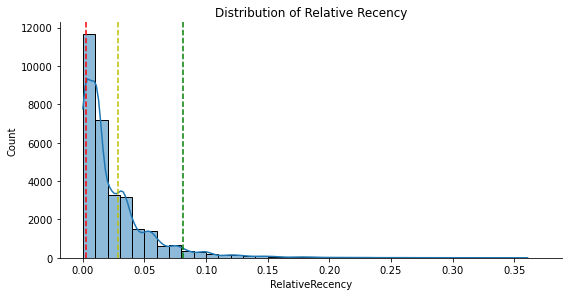

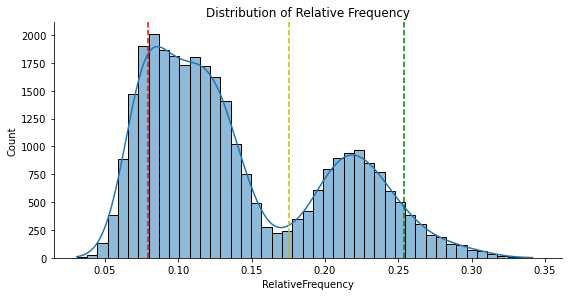

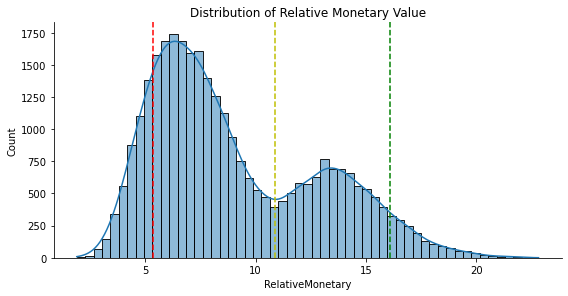

In [123]:
agg_customer_data = aggregated_customer_df.copy()
agg_customer_data['RelativeRecency'] = agg_customer_data['recency']/agg_customer_data['lifetime']
agg_customer_data['RelativeFrequency'] = agg_customer_data['frequency']/agg_customer_data['lifetime']
agg_customer_data['RelativeMonetary'] = agg_customer_data['monetary_value']/agg_customer_data['lifetime']

# Plot RFM distributions
sns.displot(agg_customer_data['RelativeRecency'], binwidth = 0.01, kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeRecency.quantile(0.15), label='Relative Recency Median', color='r', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeRecency.quantile(0.7), label='Relative Recency Median', color='y', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeRecency.quantile(0.95), label='Relative Recency Median', color='g', linestyle='--')
plt.title('Distribution of Relative Recency')

sns.displot(agg_customer_data['RelativeFrequency'], binwidth = 0.007, kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeFrequency.quantile(0.15), label='Relative Frequency Median', color='r', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeFrequency.quantile(0.7), label='Relative Frequency Median', color='y', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeFrequency.quantile(0.95), label='Relative Recency Median', color='g', linestyle='--')
plt.title('Distribution of Relative Frequency')

sns.displot(agg_customer_data['RelativeMonetary'].astype(float), kde=True, height=4, aspect=2)
plt.axvline(x=agg_customer_data.RelativeMonetary.quantile(0.15), label='Relative Frequency Median', color='r', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeMonetary.quantile(0.7), label='Relative Frequency Median', color='y', linestyle='--')
plt.axvline(x=agg_customer_data.RelativeMonetary.quantile(0.95), label='Relative Recency Median', color='g', linestyle='--')
plt.title('Distribution of Relative Monetary Value')
plt.show

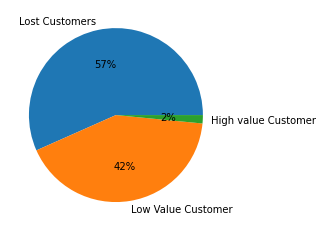

In [144]:
# define rfm threshold values for high, med, and low
# high_r = agg_customer_data.RelativeRecency.quantile(0.9)
# high_f = agg_customer_data.RelativeFrequency.quantile(0.9)
# high_m = agg_customer_data.RelativeMonetary.quantile(0.9)
h = 0.7
med_r = agg_customer_data.RelativeRecency.quantile(h)
med_f = agg_customer_data.RelativeFrequency.quantile(h)
med_m = agg_customer_data.RelativeMonetary.quantile(h)
l = 0.7
low_r = agg_customer_data.RelativeRecency.quantile(l)
low_f = agg_customer_data.RelativeFrequency.quantile(l)
low_m = agg_customer_data.RelativeMonetary.quantile(l)

# segment customers into rfm categories: low value, medium value, high value, and top value
# top_condition = (agg_customer_data['RelativeRecency'] > high_r) & (agg_customer_data['RelativeFrequency'] > high_f) & (agg_customer_data['RelativeMonetary'] > high_m)
high_condition = (agg_customer_data['RelativeRecency'] >= med_r) & (agg_customer_data['RelativeFrequency'] >= med_f) & (agg_customer_data['RelativeMonetary'] >= med_m) & (agg_customer_data['RelativeRecency'] <= high_r) & (agg_customer_data['RelativeFrequency'] <= high_f) & (agg_customer_data['RelativeMonetary'] <= high_m)
# med_condition = (agg_customer_data['RelativeRecency'] >= low_r) & (agg_customer_data['RelativeFrequency'] >= low_f) & (agg_customer_data['RelativeMonetary'] >= low_m) & (agg_customer_data['RelativeRecency'] <= med_r) & (agg_customer_data['RelativeFrequency'] <= med_f) & (agg_customer_data['RelativeMonetary'] <= med_m)
low_condition = (agg_customer_data['RelativeRecency'] < low_r) & (agg_customer_data['RelativeFrequency'] < low_f) & (agg_customer_data['RelativeMonetary'] < low_m)

# create dataframes for customer segments
agg_customer_data_labelled = agg_customer_data.copy()
# agg_customer_data_labelled['customer_segment'] = np.where(top_condition, 'Top Customers')
# agg_customer_data_labelled

# agg_customer_data_labelled['customer_segment'] = np.where(
# 										high_condition,
# 										"High value Customer",
# 										(np.where(
# 	med_condition,
# 							"Med Value Customer",
# 							np.where(low_condition,
# 							'Low Value Customer', 'Lost Customers'))))
# # agg_customer_data_labelled.head(20)

agg_customer_data_labelled['customer_segment'] = np.where(
										high_condition,
										"High value Customer",
										
							np.where(low_condition,
							'Low Value Customer', 'Lost Customers'))
# agg_customer_data_labelled.head(20)


# plt.figure(figsize=(7,7))
# plt.pie(agg_customer_data_labelled.customer_segment.value_counts(), labels=agg_customer_data_labelled['customer_segment'])
# plt.title('RFM Customer Segments')
# plt.show()


plt.pie(agg_customer_data_labelled.customer_segment.value_counts(),
        labels=agg_customer_data_labelled.customer_segment.value_counts().index,
        autopct='%.0f%%')
plt.show()


# top_value_customers = agg_customer_data[top_condition]
# high_value_customers = agg_customer_data[high_condition]
# medium_value_customers = agg_customer_data[med_condition]
# low_value_customers = agg_customer_data[low_condition]